In [1]:
import os
import pickle
import string
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/bnaturebengali-image-captioning-dataset'
WORKING_DIR = '/kaggle/working'

In [3]:
# load InceptionV3 model
model = InceptionV3(weights ='imagenet')
# restructure the model
model = Model(model.input, model.layers[-2].output)
# summarize
print(model.summary())

2022-08-25 05:02:16.754337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 05:02:16.863946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 05:02:16.864684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-25 05:02:16.865773: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

96124928/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Pictures')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for InceptionV3
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8000 [00:00<?, ?it/s]

2022-08-25 05:02:22.588699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-25 05:02:24.674783: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'caption','caption.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
captions_doc

'1.jpg   দুই শিশু গ্রামে হাঁটছে।\n1.jpg   একটা নীল জামা পড়া শিশু।\n1.jpg   দুই শিশু খেলা করে।\n1.jpg   দুইটা শিশু দাঁড়িয়ে আছে।\n2.jpg   কিছু লোক নদী পার করছে।\n2.jpg   কিছু লোক বিল পার করছে।\n2.jpg   অনেকগুলো লোক নদী পার করছে।\n2.jpg   জমির ভিতর অনেকগুলো লোক।\n2.jpg   কিছু লোক নদী পার করছে।\n3.jpg   এক কৃষক ক্ষেতে কাজ করছে।\n3.jpg   এক কৃষক ধান ক্ষেতে কাজ করছে।\n3.jpg   রোদ এর নিচে একটা লোক দাঁড়িয়ে আছে।\n3.jpg   এক কৃষক ধান দেখছে।\n3.jpg   শার্ট পড়া একটা লোক।\n4.jpg   কিছু শিশু তাদের স্কুল থেকে বাড়িতে যায়।\n4.jpg   কিছু শিশু ও একটি ভবন।\n4.jpg   ভবনে কিছু শিশু খেলা করে।\n4.jpg   সবুজ ধান ক্ষেত।\n4.jpg   স্কুলের জামা পড়া কিছু শিশু।\n5.jpg   পাঁচটি নারী এক জায়গায় চলছে।\n5.jpg   পাঁচটি শিশু এক জায়গায় চলছে।\n5.jpg   পাঁচটি মেয়ে খেলছে।\n5.jpg   হাসিমুখে পাঁচটি মেয়ে।\n5.jpg   পাঁচটি মেয়ে খেলতেছে।\n6.jpg   কিছু লোক পাহাড়ে বসে আছে।\n6.jpg   কিছু লোক বসে আছে।\n6.jpg   রোদ এর নিছে কিছু লোক বসে আছে।\n6.jpg   পাহারের উপর কিছু লোক বসে আছে।\n6.jpg   হাসিমুখে কিছু লোক বসে আছে।\n7.jpg   নদীর পা

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/39106 [00:00<?, ?it/s]

In [10]:
len(mapping)

8000

In [11]:
mapping['9']

['  মানুষ আকর্ষণ সঙ্গে ধান কাটা দেখছে।',
 '  একটি লোক ধান কাটছে আর কিছু লোক দেখছে।',
 '  অনেকগুলো মানুষ ধান কাটা দেখছে।',
 '  অনেকগুলো মানুষ ধান কাটার যন্ত্র দিয়ে ধান কাটা দেখছে।',
 '  মানুষ আকর্ষণ সঙ্গে কিছু দেখছে।']

## Preprocess The text data

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('।', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
clean(mapping)

In [14]:
mapping['9']

['startseq মানুষ আকর্ষণ সঙ্গে ধান কাটা দেখছে endseq',
 'startseq একটি লোক ধান কাটছে আর কিছু লোক দেখছে endseq',
 'startseq অনেকগুলো মানুষ ধান কাটা দেখছে endseq',
 'startseq অনেকগুলো মানুষ ধান কাটার যন্ত্র দিয়ে ধান কাটা দেখছে endseq',
 'startseq মানুষ আকর্ষণ সঙ্গে কিছু দেখছে endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

39104

In [17]:
all_captions[:5]

['startseq দুই শিশু গ্রামে হাঁটছে endseq',
 'startseq একটা নীল জামা পড়া শিশু endseq',
 'startseq দুই শিশু খেলা করে endseq',
 'startseq দুইটা শিশু দাঁড়িয়ে আছে endseq',
 'startseq কিছু লোক নদী পার করছে endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

9920

In [20]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

41

## Train Test split


In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

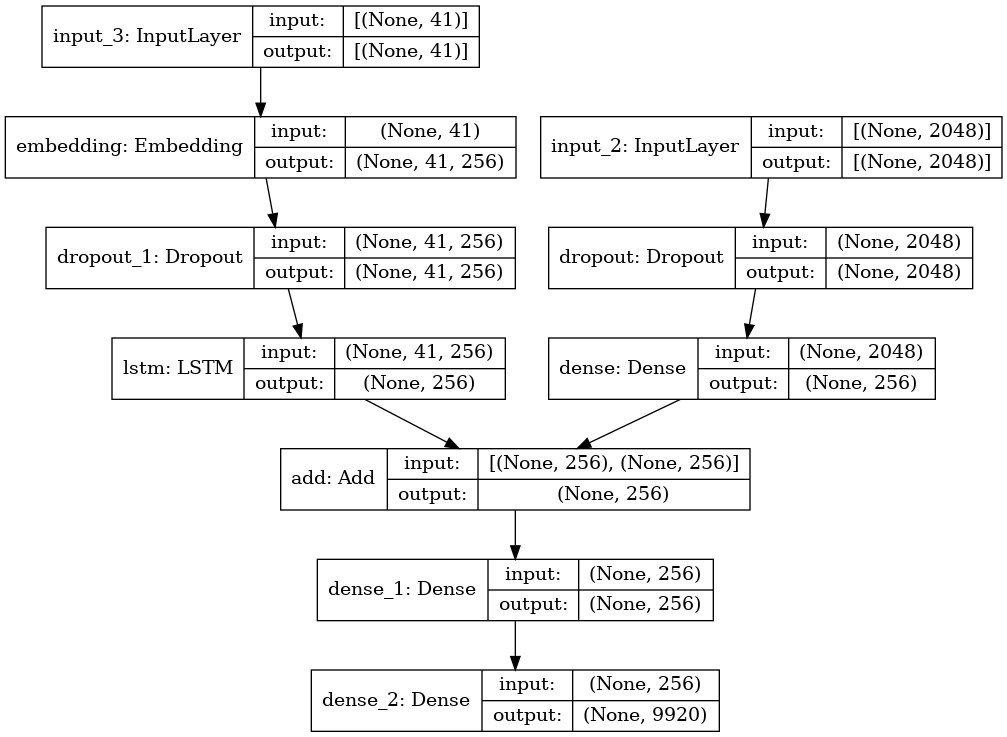

In [23]:
##Model Creation
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

225/225 [==============================] - 60s 267ms/step - loss: 1.9393


In [25]:
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.34, 0.33, 0.33, 0)))

  0%|          | 0/800 [00:00<?, ?it/s]

BLEU-1: 0.476643
BLEU-2: 0.289017
BLEU-3: 0.150947


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
   
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Pictures", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq দুইজন নারী, একজন শিশু পাচজন পুরুষ বসে আছে endseq
startseq কয়েকজন ছেলে মেয়ে নদীতে নৌকার উপর বসে আছে endseq
startseq একটি নৌকার ওপর কিছু নারী পুরুষ বসে আছে endseq
startseq নদীর জলে কচুরিপানা গুলো ভাসছে endseq
startseq নদীতে একটি নৌকা ভাসছে endseq
--------------------Predicted--------------------
startseq একটি শপিংমলের সামনে অনেক মানুষ হাটছে endseq


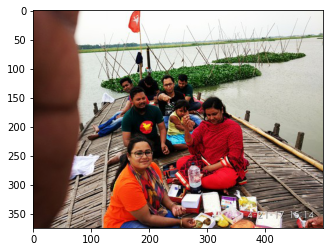

In [30]:
generate_caption("7251.jpg")

---------------------Actual---------------------
startseq পাশাপাশি দুইটি নৌকায় কয়েকজন মানুষ আছে endseq
startseq টি নৌকায় কিছু মানুষ যারা নদী পাড় হচ্ছেন endseq
startseq মানুষগুলো নৌকা দিয়ে নদী পার হচ্ছে endseq
startseq নদীতে কিছু নৌক আছে endseq
startseq নদীতে নৌকা গুলো যাত্রি পার করছে endseq
--------------------Predicted--------------------
startseq একটি নৌকায় একজন মানুষ আছে endseq


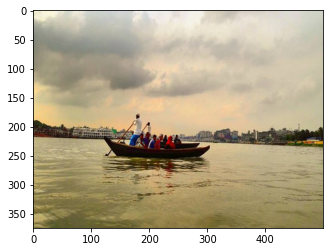

In [31]:
generate_caption("6091.jpg")